<a href="https://colab.research.google.com/github/dianulka/computational-intelligence-in-digital-data-analysis/blob/main/lab03/gymnasium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Podstawy Gymnasium

In [29]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [30]:
class WalkingCliff:
    def __init__(
            self,
            env: gym.Env,
            learning_rate: float,
            initial_epsilon: float,
            epsilon_decay: float,
            final_epsilon: float,
            discount_factor: float = 0.9,
            is_train: bool = True,
    ):
        """Initialize a Reinforcement Learning agent with an empty numpy array (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value, measures the importance of future rewards.
            is_train: Whether the agent is in training mode or not.
        """
        self.env = env


        if is_train:
            self.q_values = np.zeros((env.observation_space.n, env.action_space.n))
        else:
            with open('walking_cliff_model.pkl', 'rb') as f:
                self.q_values = pickle.load(f)


        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.is_train = is_train

    def get_action(self, observation):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random() < self.epsilon and self.is_train:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_values[observation])

    def update(self, observation, action, reward, terminated, next_observation):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_observation])

        temporal_difference = (
                reward + self.discount_factor * future_q_value - self.q_values[observation][action]
        )

        self.q_values[observation][action] = (
                self.q_values[observation][action] + self.lr * temporal_difference
        )


    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)



In [31]:
def run_agent(agent, env, n_episodes):

  for episode in (range(n_episodes)):
      obs, info = env.reset()
      done = False

      # play one episode
      while not done:
          action = agent.get_action(obs)
          next_obs, reward, terminated, truncated, info = env.step(action)


          if agent.is_train:
              # update the agent
              agent.update(obs, action, reward, terminated, next_obs)

          # update if the environment is done and the current obs
          done = terminated or truncated
          obs = next_obs

      agent.decay_epsilon()




In [32]:
def plot_results(env, is_train, rolling_length=500):

  def get_moving_avgs(arr, window, convolution_mode):
      return np.convolve(
          np.array(arr).flatten(),
          np.ones(window),
          mode=convolution_mode
      ) / window

  # Smooth over a 500 episode window
  rolling_length = 500
  fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

  axs[0].set_title("Episode rewards")
  reward_moving_average = get_moving_avgs(
      env.return_queue,
      rolling_length,
      "valid"
  )
  axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
  axs[0].axhline(y=-13, color='red', linestyle='--')


  axs[1].set_title("Episode lengths")
  length_moving_average = get_moving_avgs(
      env.length_queue,
      rolling_length,
      "valid"
  )
  axs[1].plot(range(len(length_moving_average)), length_moving_average)

  plt.tight_layout()
  plt.savefig(f"cliff_{'train' if is_train else 'test'}.png")

  plt.show()

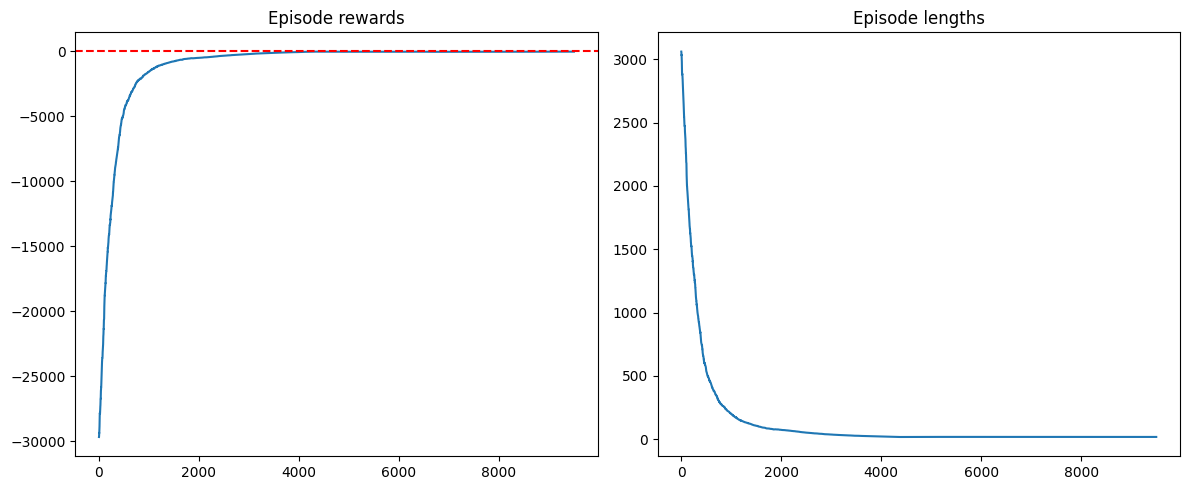

In [33]:
# hyperparameters
learning_rate = 0.01
n_train_episodes = 10_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_train_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1


env_train = gym.make('CliffWalking-v0')
env_train = gym.wrappers.RecordEpisodeStatistics(env_train, buffer_length=n_train_episodes)

agent_train = WalkingCliff(
    env=env_train,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    is_train= True
)

run_agent(agent_train, env_train, n_train_episodes)

if agent_train.is_train:
    with open('walking_cliff_model.pkl', 'wb') as f:
        pickle.dump(agent_train.q_values, f)

plot_results(env_train, agent_train.is_train)


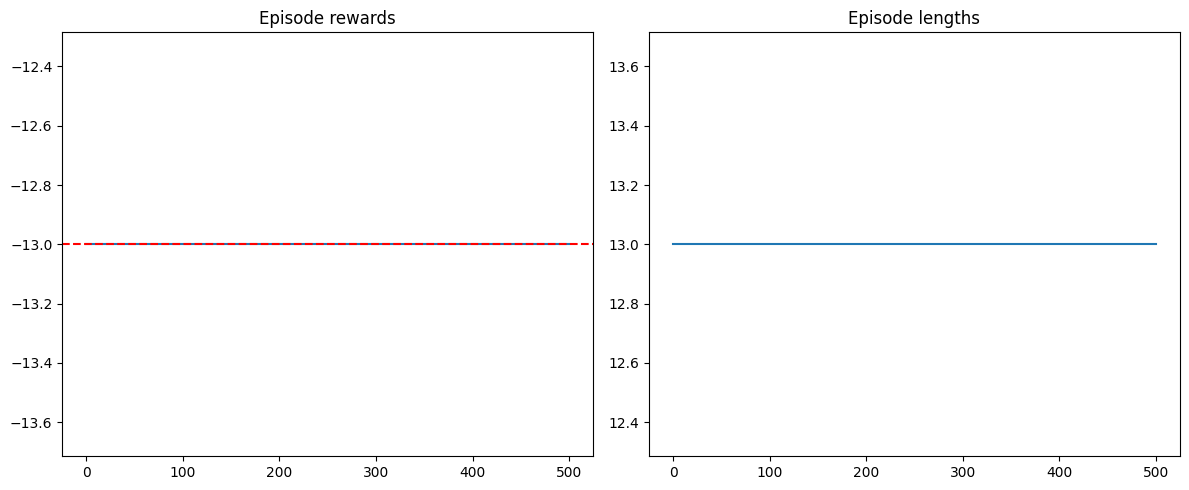

In [35]:
n_test_episodes = 1000

env_test = gym.make('CliffWalking-v0')
env_test = gym.wrappers.RecordEpisodeStatistics(env_test, buffer_length=n_test_episodes)

agent_test = WalkingCliff(
    env=env_test,
    learning_rate=learning_rate,
    initial_epsilon=0.0,
    epsilon_decay=0.0,
    final_epsilon=0.0,
    is_train=False
)

run_agent(agent_test, env_test, n_test_episodes)
plot_results(env_test, False)
